<h1>Моделирование стоимости под риском (VaR) -- исторический метод</h1>

<p>Разработано Драчуком А. для The Foundation</p>
<a href="https://t.me/LYFTN">Следите за нами в Телеграм</a>

<h3>Импортируем необходимые библиотеки</h3>

In [2]:
import numpy as np        #библиотека для работы с массивами и матрицами
import pandas as pd        #библитека для работы с данными
import datetime as dt        #библиотека для работы с временными рядами
import yfinance as yf        #библиотека для работы с данными с Yahoo Finance
import matplotlib.pyplot as plt        #импорт модуля для формирования графиков из библиотеки для визуализации данных

<h3>Задаем глубину фактических данных для анализа</h3>

In [3]:
years = 15        #указываем кол-во лет для анализа

endDate = dt.datetime.now()        #задаем конечную дату -- текущий момент времени
startDate = endDate - dt.timedelta(days = 365 * years)        #начальная дата: текущий момент времени - кол-во лет

<h3>Формируем массив тикеров ценных бумаг, из которых формируем портфель</h3>

In [4]:
#SPY -- SPDR S&P 500 ETF Trust
#BND -- Vanguard Total Bond Market Index Fund 
#GLD -- SPDR Gold Shares
#QQQ -- Invesco QQQ Trust
#VTI -- Vanguard Total Stock Market Index Fund ETF Shares 
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [5]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']
    
print(adj_close_df)        #проверяем корректность выгрузки

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-05-29   69.809738  50.387756   96.199997   30.926025   35.151825
2009-06-01   71.499680  50.047123   95.730003   31.808874   36.024349
2009-06-02   71.560081  50.236340   96.360001   31.852587   36.168518
2009-06-03   70.654709  50.406025   94.410004   31.756426   35.728451
2009-06-04   71.318665  50.092781   96.230003   32.114815   36.085064
...                ...        ...         ...         ...         ...
2024-05-20  530.059998  71.739998  224.559998  454.910004  262.570007
2024-05-21  531.359985  71.889999  224.229996  455.799988  263.109985
2024-05-22  529.830017  71.800003  220.110001  455.709991  262.220001
2024-05-23  525.960022  71.589996  215.720001  453.660004  259.989990
2024-05-24  529.059998  71.675003  215.889893  457.820007  261.600006

[3774 rows x 5 columns]


<h3>Преобразовываем массив дневных цен в массив дневных доходностей</h3>

In [6]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))        #рассчитываем натуральный логарифм дневной доходности ценных бумаг
log_returns = log_returns.dropna()        #удаляем строки со значениями NaN 

print(log_returns)        #проверяем массив

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-06-01  0.023919 -0.006783 -0.004898  0.028147  0.024519
2009-06-02  0.000844  0.003774  0.006559  0.001373  0.003994
2009-06-03 -0.012733  0.003372 -0.020444 -0.003024 -0.012242
2009-06-04  0.009353 -0.006234  0.019094  0.011222  0.009932
2009-06-05  0.000211 -0.006797 -0.026536  0.001089 -0.001894
...              ...       ...       ...       ...       ...
2024-05-20  0.001151 -0.000975  0.004016  0.006949  0.001029
2024-05-21  0.002450  0.002089 -0.001471  0.001954  0.002054
2024-05-22 -0.002883 -0.001253 -0.018545 -0.000197 -0.003388
2024-05-23 -0.007331 -0.002929 -0.020146 -0.004509 -0.008541
2024-05-24  0.005877  0.001187  0.000787  0.009128  0.006174

[3773 rows x 5 columns]


<h3>Рассчитываем веса для равновесного инвестиционого портфеля</h3>

In [23]:
weights = np.array([1/len(tickers)] * len(tickers))        #формируем массив из одинаковых весов

print(weights)        #проверяем веса

[0.2 0.2 0.2 0.2 0.2]


<h3>Определяем историческую дневную доходность равновесного портфеля</h3>

In [24]:
historical_returns = (log_returns * weights).sum(axis = 1)        #доходность портфеля в конкретный день = сумма взвешенных доходностей инструментов за этот день

print(historical_returns)        #проверяем результат

Date
2009-06-01    0.012981
2009-06-02    0.003309
2009-06-03   -0.009014
2009-06-04    0.008674
2009-06-05   -0.006786
                ...   
2024-05-20    0.002434
2024-05-21    0.001415
2024-05-22   -0.005253
2024-05-23   -0.008691
2024-05-24    0.004630
Length: 3773, dtype: float64


<h3>Находим доходность портфеля на рассматриваемом горизонте расчета</h3>

In [25]:
days = 5        #кол-во дней, для которого рассчитывается стоимость под риском

range_returns = historical_returns.rolling(window = days).sum()       #методом rolling() мы задаем скользящее окно (window), равное кол-ву дней (days), для которого рассчитывается доходность. Для сборки массива суммируем значения 
range_returns = range_returns.dropna()        #удаляем строки со значениями NaN 

print(range_returns)        #проверяем результат -- поскольку указали окно в 5 дней, кол-во значений должно быть на (5-1) меньше, чем кол-во значений дневной доходности

Date
2009-06-05    0.009164
2009-06-08   -0.006532
2009-06-09   -0.005122
2009-06-10    0.001740
2009-06-11   -0.004241
                ...   
2024-05-20    0.020487
2024-05-21    0.016459
2024-05-22   -0.000633
2024-05-23   -0.006851
2024-05-24   -0.005465
Length: 3769, dtype: float64


<h3>Находим распределение доходности портфеля в долларах</h3>

In [28]:
portfolio_value = 1000000        #стоимость портфеля

range_returns_dollar = range_returns * portfolio_value

print(range_returns_dollar)

Date
2009-06-05     9163.841140
2009-06-08    -6532.198539
2009-06-09    -5121.598663
2009-06-10     1740.122195
2009-06-11    -4240.853889
                  ...     
2024-05-20    20487.256332
2024-05-21    16458.704082
2024-05-22     -633.294888
2024-05-23    -6851.114158
2024-05-24    -5464.855566
Length: 3769, dtype: float64


<h3>Задаем доверительный интервал и рассчитываем Стоимость под риском (VaR) на заданном временном горизонте</h3>

In [38]:
confidence_interval = 0.95        #доверительный интервал

VaR = -np.percentile(range_returns, 100 * (1 - confidence_interval)) * portfolio_value        #рассчитываем VaR

print(VaR)        #выводим результат 

24076.78685205404


<h3>Визуализируем результаты оценки VaR историческим методом на график</h3>

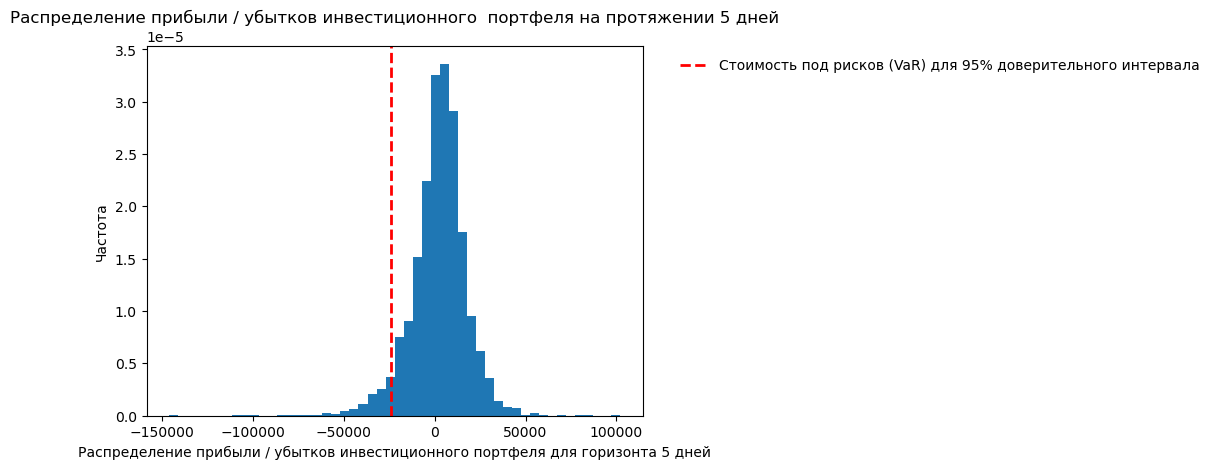

In [39]:
plt.hist(range_returns_dollar, bins = 50, density = True)
plt.xlabel(f'Распределение прибыли / убытков инвестиционного портфеля для горизонта {days} дней')
plt.ylabel('Частота')
plt.title(label=f'Распределение прибыли / убытков инвестиционного  портфеля на протяжении {days} дней')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, 
            label = f'Стоимость под рисков (VaR) для {confidence_interval:.0%} доверительного интервала')
plt.legend(loc='upper center', bbox_to_anchor=(1.6, 1.0),
          frameon=False, shadow=False, ncol=5)
plt.show()